Here is the prompt I asked ChatGPT:"Can you write a Jupyter notebook which uses fastai to download cat and dog images to train a model to identify dogs and cats?"

I used ChatGPT for iOS 1.2024.206 (10172611049).

Here is ChatGPT's response to prompt (which I copied into this Jupyter Notebook):

*Sure! Below is a Jupyter notebook that uses fastai to download images of cats and dogs and trains a model to identify them.*

I have copied the respone

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.160278,0.017605,0.008119,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.076435,0.033412,0.010825,00:41
1,0.041775,0.020396,0.007442,00:43
2,0.025687,0.010429,0.004060,00:41
3,0.012092,0.007681,0.002706,00:42


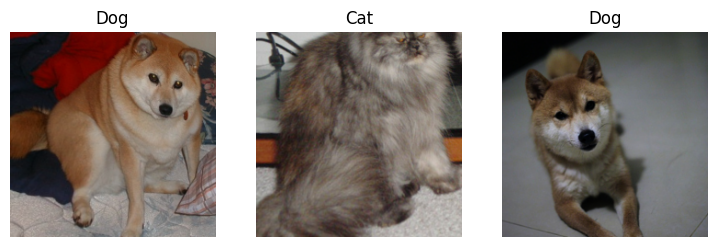

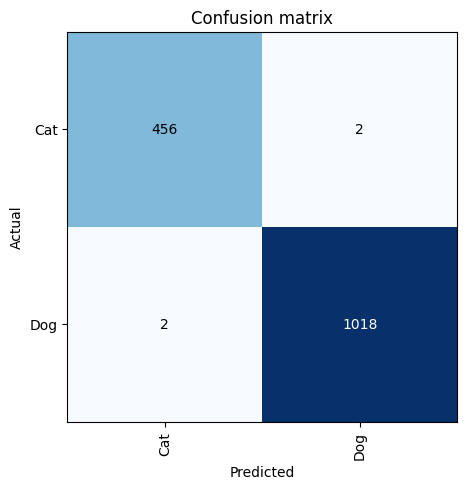

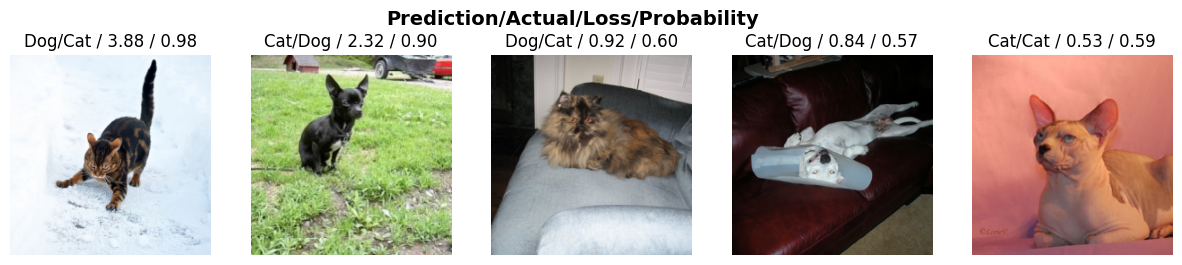

In [1]:
# # %% [markdown]
# # Cats vs Dogs Classifier using fastai
# 
# This notebook demonstrates how to use the fastai library to download images of cats and dogs, and train a model to distinguish between them.

# %%
# Install fastai if not already installed
!pip install -Uqq fastai

# %%
from fastai.vision.all import *
from fastai.data.external import untar_data, URLs

# %%
# Download the dataset
path = untar_data(URLs.PETS)
path

# %%
# The dataset has images and annotations. We only need the images.
(path/'images').ls()

# %%
# The fastai library provides a convenient way to get labels from file names
#def is_cat(x): return x[0].isupper()
# revised
# def is_cat(x): return x.name[0].isupper()

# Revised is_cat(x) method
#     TypeError: 'PosixPath' object is not subscriptable caused by x[0]
#     This does not work because a Path object is being sent as the input to the function
#     X is a Path object and x[0] is returning "/" for every call
#     I would like to determine what gets passed into get_y function.  It seems to change per type of data block.
def is_cat(x): 
    if x.name[0].isupper():
        return "Cat"
    else:
        return "Dog"


# %%
# Create a DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Data types
    get_items=get_image_files,          # How to get the items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Train/validation split
    get_y=is_cat,                       # How to get the labels
    item_tfms=Resize(460),              # Resize images to 460 pixels
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # Data augmentation and resize to 224 pixels
)

# %%
# Load the data
dls = dblock.dataloaders(path/"images")

# %%
# Show some examples
dls.show_batch(nrows=1, ncols=3)

# %%
# Create a learner object and train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# %%
# Fine-tune the model
learn.fine_tune(4)

# %%
# Plot confusion matrix to see the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# %%
# Show some misclassified images
interp.plot_top_losses(5, nrows=1)

To use this notebook:

	1.	Make sure you have Jupyter Notebook or JupyterLab installed.
	2.	Save this notebook code into a .ipynb file.
	3.	Run the notebook. It will download the dataset, preprocess the images, train a ResNet34 model, and display the results.

This notebook assumes you have a working Python environment with the fastai library installed. If not, you can install it by running !pip install -Uqq fastai in a Jupyter cell.

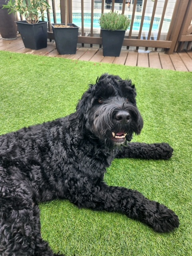

The model thinks Max is a Dog.
Probability it's a dog: 1.0000
Probability it's a cat: 0.0000


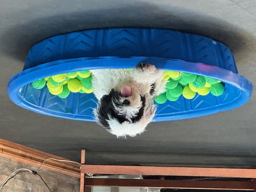

The model thinks Lucy is a Cat.
Probability it's a dog: 0.0706
Probability it's a cat: 0.9294


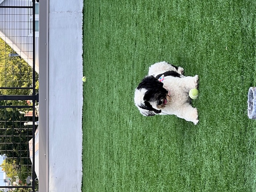

The model thinks Lucy is a Dog.
Probability it's a dog: 0.7799
Probability it's a cat: 0.2201


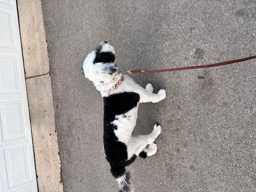

The model thinks Lucy is a Dog.
Probability it's a dog: 0.9459
Probability it's a cat: 0.0541


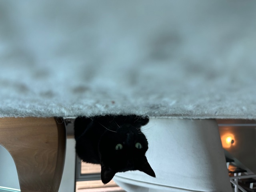

The model things Chica is a Cat.
Probability it's a dog: 0.4075
Probability it's a cat: 0.5925


In [17]:
from fastdownload import download_url
from fastai.vision.all import *

# Test the model using the image of Max (see My Family Pets dataset)
max_file = "../input/my-family-pets/Max.jpg"
max_image = Image.open(max_file).to_thumb(256, 256)
result,_,prob = learn.predict(max_image)
display(max_image)
print(f"The model thinks Max is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using Lucy's first image (see My Family Pets dataset)
lucy_file = "../input/my-family-pets/Lucy.jpg"
lucy_image = Image.open(lucy_file).to_thumb(256, 256)
result,_,prob = learn.predict(lucy_image)
display(lucy_image)
print(f"The model thinks Lucy is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using Lucy's second image (see My Family Pets dataset)
lucy_file2 = "../input/my-family-pets/Lucy_2.jpg"
lucy_image2 = Image.open(lucy_file2).to_thumb(256, 256)
result,_,prob = learn.predict(lucy_image2)
display(lucy_image2)
print(f"The model thinks Lucy is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using Lucy's third image (see My Family Pets dataset)
lucy_file3 = "../input/my-family-pets/Lucy_3.jpg"
lucy_image3 = Image.open(lucy_file3).to_thumb(256, 256)
result,_,prob = learn.predict(lucy_image3)
display(lucy_image3)
print(f"The model thinks Lucy is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")

# Test the model using Chica's image (see My Family Pets dataset)
chica_file = '../input/my-family-pets/Chica.jpg'
chica_image = Image.open(chica_file).to_thumb(256, 256)
result,_,prob = learn.predict(PILImage.create(chica_image))
display(chica_image)
print(f"The model things Chica is a {result}.")
print(f"Probability it's a dog: {prob[1]:.4f}")
print(f"Probability it's a cat: {prob[0]:.4f}")